# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [1]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape, y_train.shape)

(40000, 3, 32, 32) (40000,)


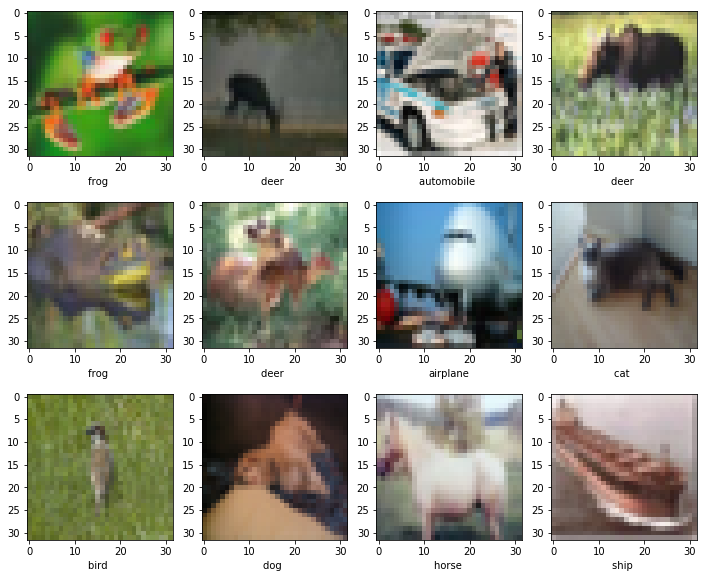

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [28]:
model = nn.Sequential()

# model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3))
# model.add_module('conv1_bn', nn.BatchNorm2d(10))
# model.add_module('pooling1', nn.MaxPool2d(kernel_size=2))
# model.add_module('conv1_relu', nn.ReLU())
# model.add_module('flatten', Flatten())
# model.add_module('dense1', nn.Linear(10 * 15 * 15, 100))
# model.add_module('dense1_bn', nn.BatchNorm1d(100))
# model.add_module('dense1_relu', nn.ReLU())
# model.add_module('dense2_logits', nn.Linear(100, 10))

model.add_module('flatten', Flatten())
model.add_module('dense1', nn.Linear(3 * 32 * 32, 100))
model.add_module('dense1_bn', nn.BatchNorm1d(100))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(100, 10))

#model = nn.Sequential()

# model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3))
# model.add_module('conv1_bn', nn.BatchNorm2d(32))
# model.add_module('conv1_relu', nn.ReLU())
# model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3))
# model.add_module('conv2_bn', nn.BatchNorm2d(64))
# model.add_module('pooling2', nn.MaxPool2d(kernel_size=2))
# model.add_module('conv2_relu', nn.ReLU())
# model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3))
# model.add_module('conv3_bn', nn.BatchNorm2d(64))
# model.add_module('conv3_relu', nn.ReLU())
# model.add_module('conv4', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3))
# model.add_module('conv4_bn', nn.BatchNorm2d(64))
# model.add_module('conv4_relu', nn.ReLU())
# model.add_module('pooling4', nn.MaxPool2d(kernel_size=2))
# model.add_module('flatten', Flatten())
# model.add_module('dense1', nn.Linear(64 * 5 * 5, 512))
# model.add_module('dense1_bn', nn.BatchNorm1d(512))
# model.add_module('dense1_relu', nn.ReLU())
# model.add_module('dense2', nn.Linear(512 , 512))
# model.add_module('dense2_bn', nn.BatchNorm1d(512))
# model.add_module('dense2_relu', nn.ReLU())
# model.add_module('dense2_logits', nn.Linear(512, 10))

# # reshape from "images" to flat vectors
# model.add_module('flatten', Flatten())

# # dense "head"
# model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
# model.add_module('dense1_relu', nn.ReLU())
# model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [16]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [25]:
# example
compute_loss(X_train[:5], y_train[:5])

Variable containing:
 2.3977
[torch.FloatTensor of size 1]

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [7]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [32]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)
# opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss_batches = []
val_accuracy_batches = []
train_loss_epochs = []
val_accuracy_epochs = []

In [41]:
from IPython.display import clear_output

def train_model(model, X_train, y_train, X_val, y_val, num_epochs=50, batch_size=128, lr=0.001):
    train_loss_batches = []
    val_accuracy_batches = []
    train_loss_epochs = []
    val_accuracy_epochs = []

    for epoch in range(num_epochs):
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
            # train on batch
            loss = compute_loss(X_batch, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss_batches.append(loss.data.numpy()[0])
        train_loss_epochs.append(np.mean(train_loss_batches[-len(X_train) // batch_size :]))

        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            logits = model(Variable(torch.FloatTensor(X_batch)))
            y_pred = logits.max(1)[1].data.numpy()
            val_accuracy_batches.append(np.mean(y_batch == y_pred))
        val_accuracy_epochs.append(np.mean(val_accuracy_batches[-len(X_val) // batch_size :]) * 100)
        
        clear_output(True)
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.title('Train loss and val accuracy')
        
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss', color='b')
        ax1.tick_params('y', colors='b')
        ax1.plot(np.arange(1, epoch + 2), train_loss_epochs, c='b')
        
        ax2 = ax1.twinx()
        ax2.set_ylabel('Accuracy', color='r')
        ax2.tick_params('y', colors='r')
        ax2.plot(np.arange(1, epoch + 2), val_accuracy_epochs, c='r')
        
        plt.show()

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss_epochs[-1]))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy_epochs[-1]))
    
    return train_loss_epochs, val_accuracy_epochs

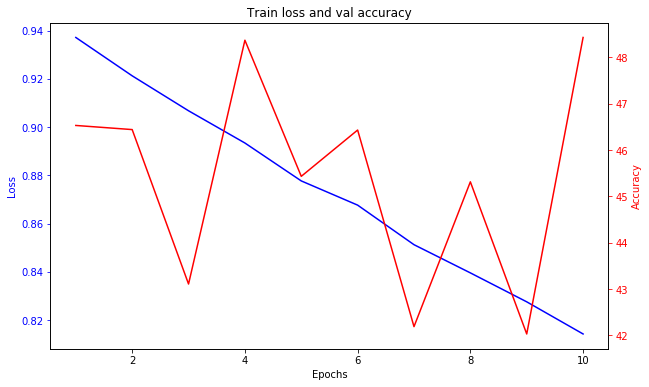

Epoch 10 of 10 took 3.400s
  training loss (in-iteration): 	0.814195
  validation accuracy: 			48.43 %


In [42]:
_ = train_model(model, X_train, y_train, X_val, y_val, num_epochs=10, batch_size=128, lr=0.001)

In [9]:
import time
num_epochs = 1 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy()[0])
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 1 took 401.547s
  training loss (in-iteration): 	1.182112
  validation accuracy: 			66.27 %


Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(Variable(torch.FloatTensor(X_batch)))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.




```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [35]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [36]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

In [ ]:
for i, img in enumerate(x_batch.numpy()[:8]):
    plt.subplot(2, 4, i+1)
    plt.imshow(img.transpose([1,2,0]) * stds + means )

In [40]:

for (x_batch, y_batch) in train_batch_gen:
    
    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
    plt.show()
    break
        
    
#     raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

X: <class 'torch.FloatTensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.LongTensor'> torch.Size([32])


ValueError: Floating point image RGB values must be in the 0..1 range.

When testing, we don't need random crops, just normalize with same statistics.

In [38]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = <YOUR CODE>

SyntaxError: invalid syntax (<ipython-input-38-587478d6ddea>, line 6)

## The Quest For A Better Network

See `practical_dl/homework02` for a full-scale assignment.